# EDA

- period : 2003-01-03 ~ 2022-12-26 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
import statsmodels.api as sm

In [4]:
# Load the data
df = pd.read_excel("core_data.xlsx")

df.columns

Index(['DATE', 'avg_price', 'pre_day_price', 'pre_year_price',
       'pre_7day_price', 'rainfall', 'snowfall', 'total_sunshine',
       'total_solar', 'average_humidity', '30cm_soil_temperature',
       'average_temperature', 'average_wind', 'oil', 'spring_income',
       'fall_income', 'cultivation_area', 'input_labor', 'cost of living',
       'CPI', 'fresh index'],
      dtype='object')

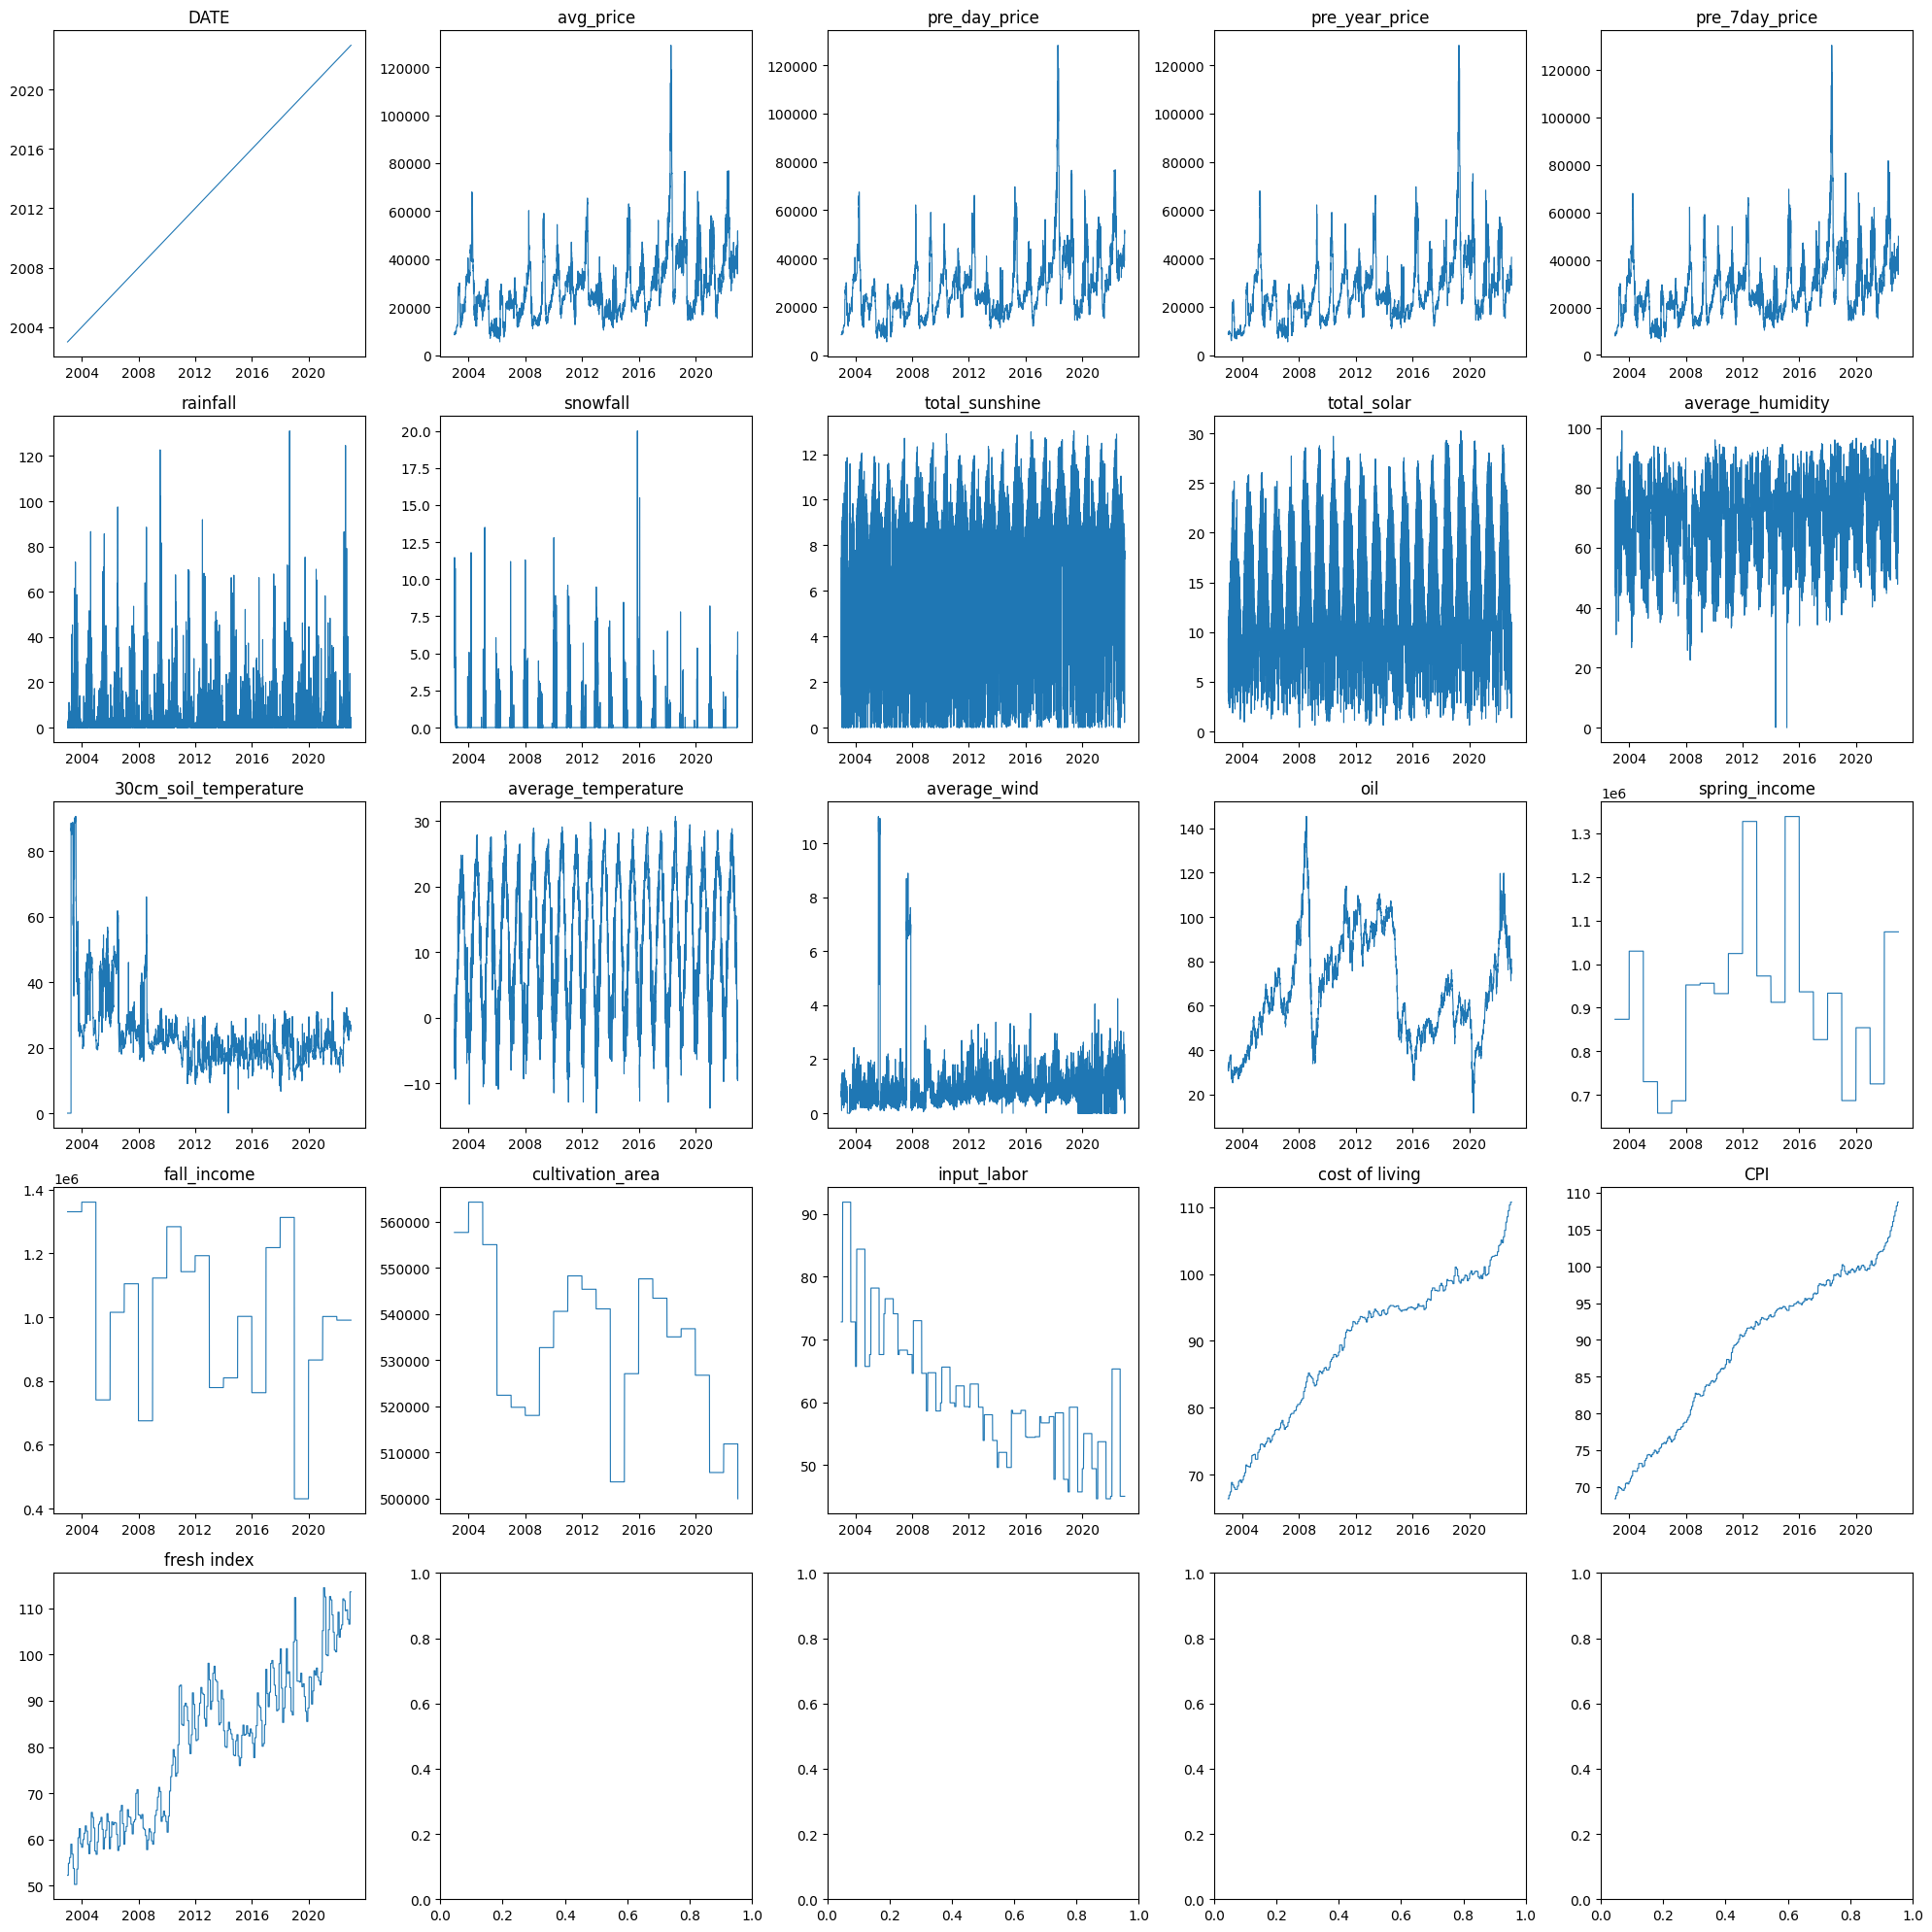

In [3]:
# plot all columns in 5x5 grid
fig, axes = plt.subplots(5, 5, figsize=(20, 20))
axes = axes.flatten()

for i, col in enumerate(df.columns):
    axes[i].plot(df["DATE"], df[col], linewidth=0.8)
    axes[i].set_title(col)
    
plt.tight_layout()
plt.show()

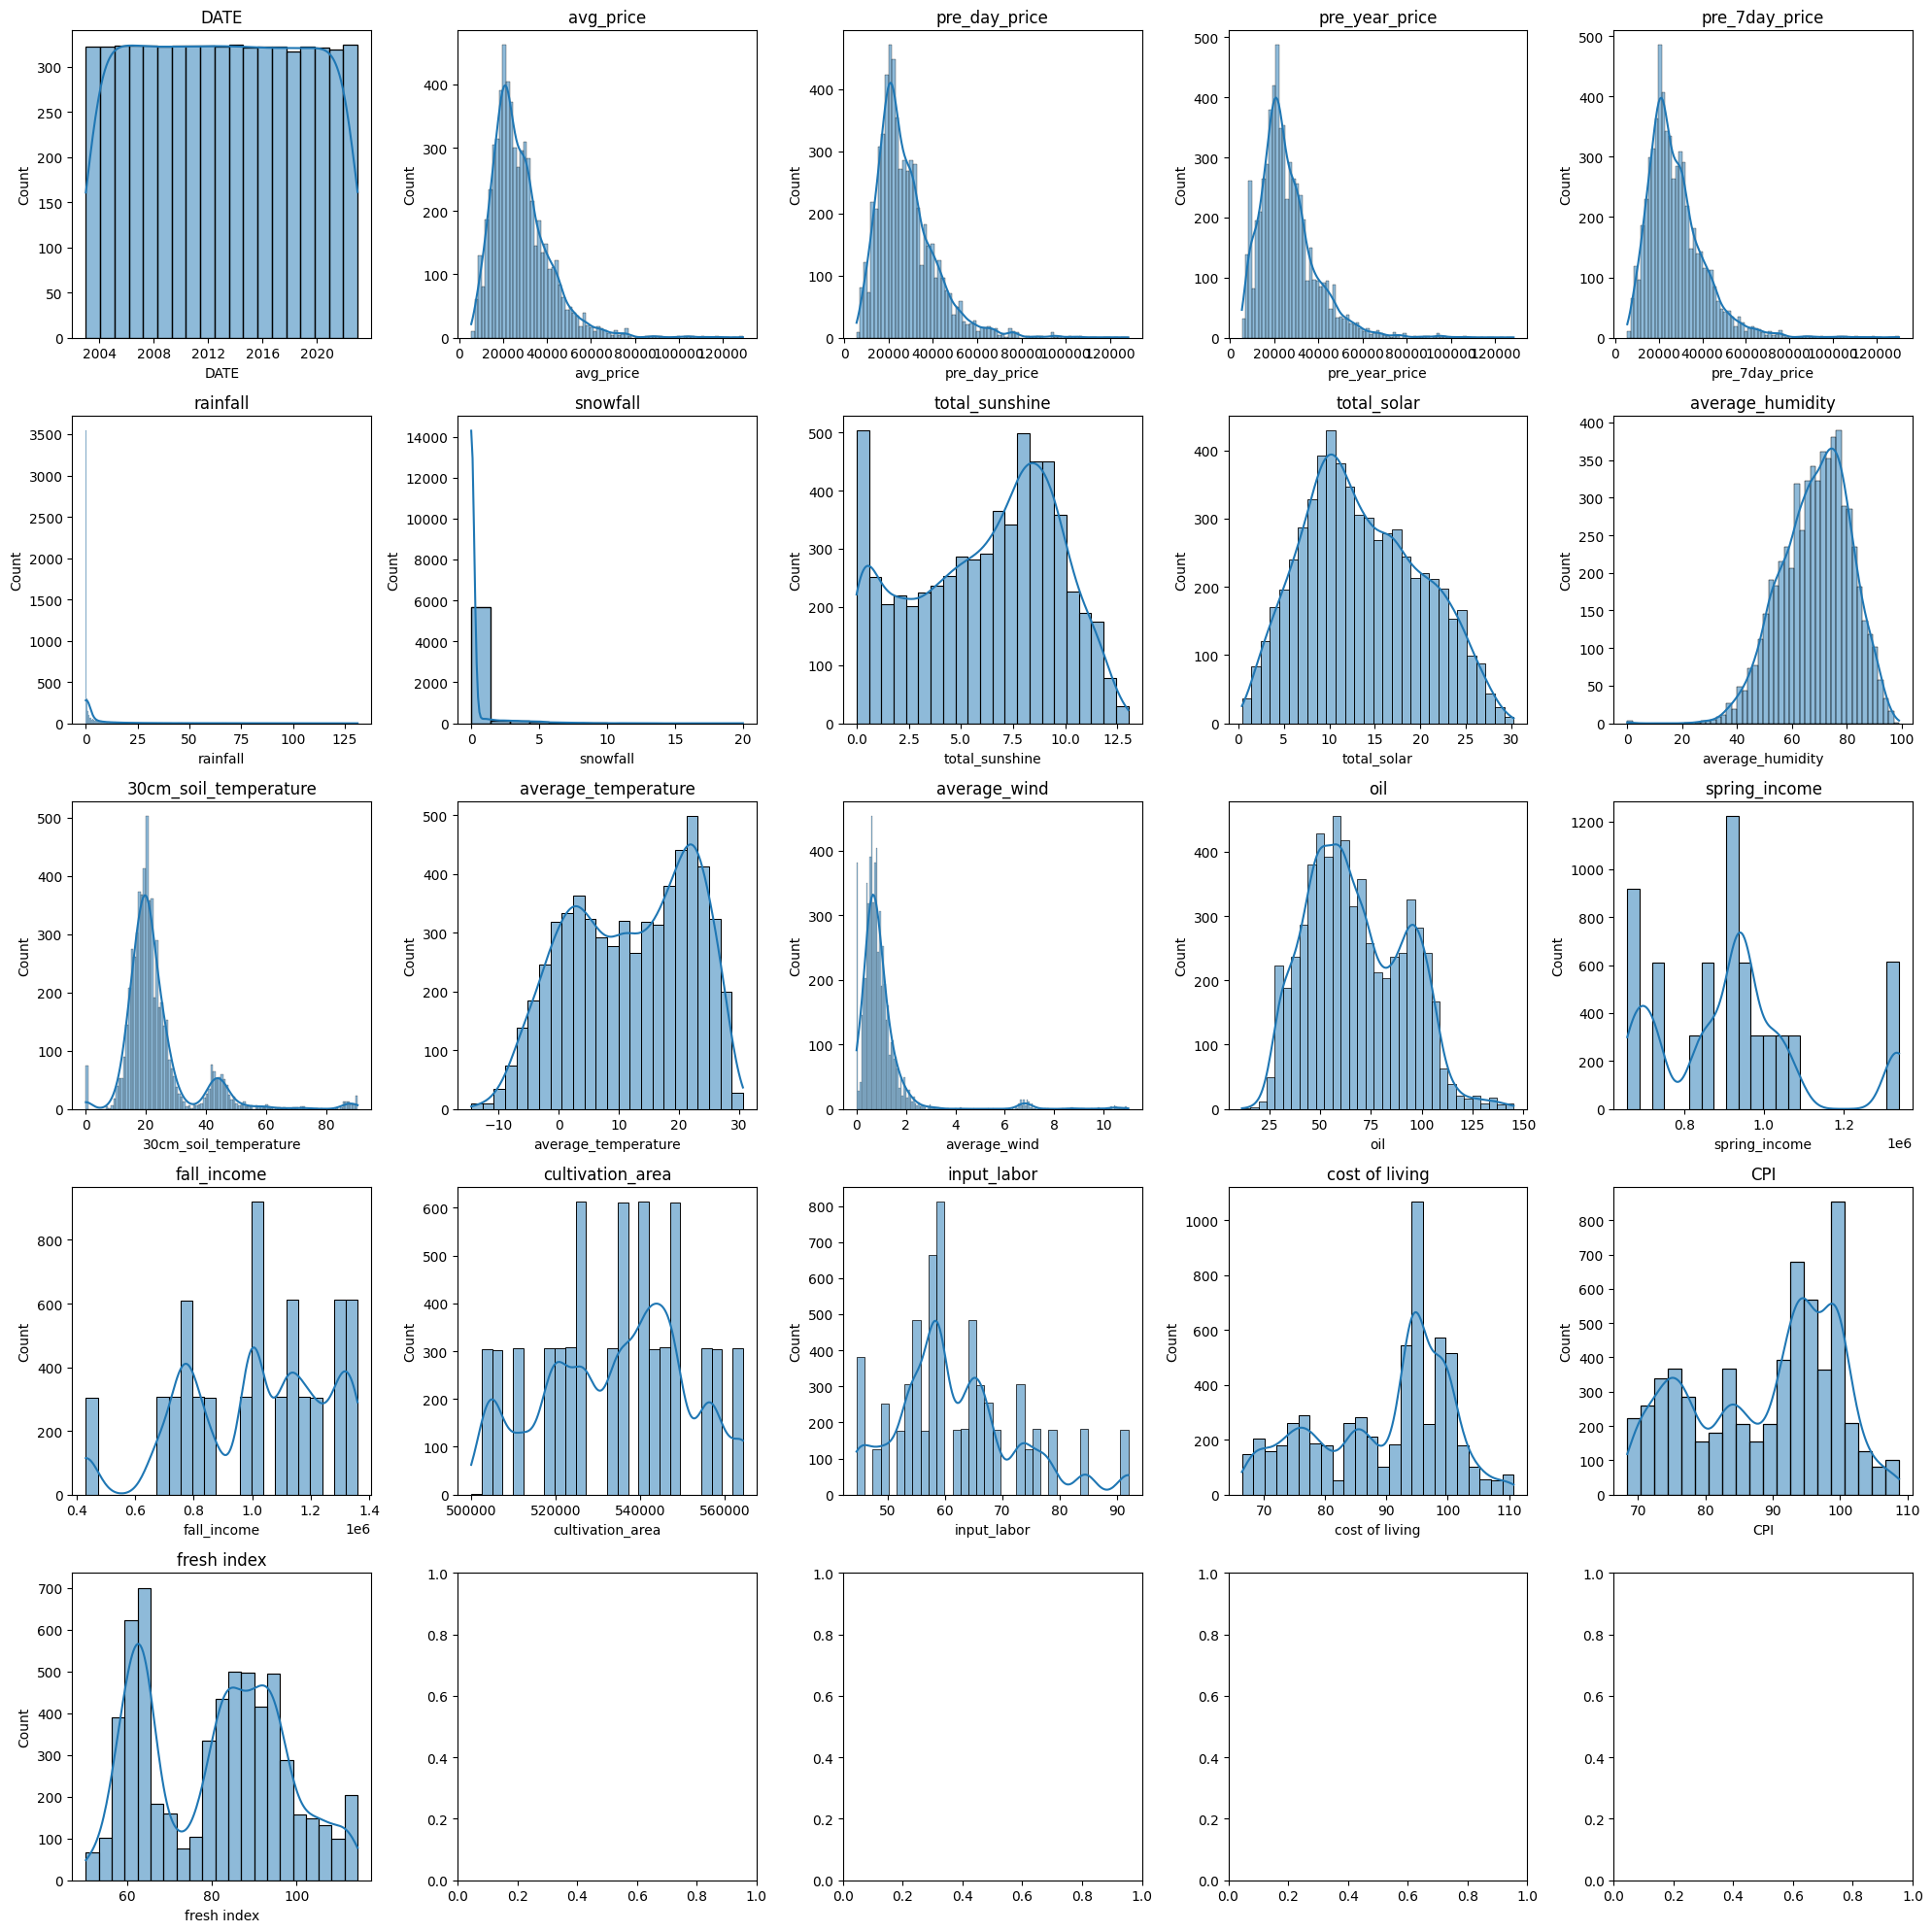

In [4]:
# plot histograms of all columns
fig, axes = plt.subplots(5, 5, figsize=(20, 20))
axes = axes.flatten()

for i, col in enumerate(df.columns):
    sns.histplot(df[col], ax=axes[i], kde=True)
    axes[i].set_title(col)
    
plt.tight_layout()
plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x308e7e310>,
 'caps': [<matplotlib.lines.Line2D at 0x30914f510>,
 'boxes': [<matplotlib.lines.Line2D at 0x305750850>],
 'medians': [<matplotlib.lines.Line2D at 0x309160450>],
 'fliers': [<matplotlib.lines.Line2D at 0x305768c10>],
 'means': []}

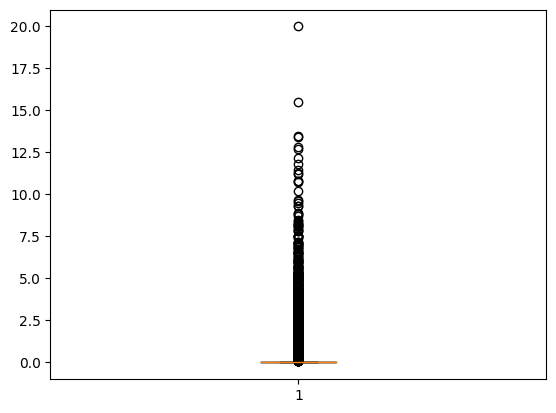

/var/folders/0t/f_9d1d5d2qv03s28lgq_4b7r0000gn/T/ipykernel_41550/714197438.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


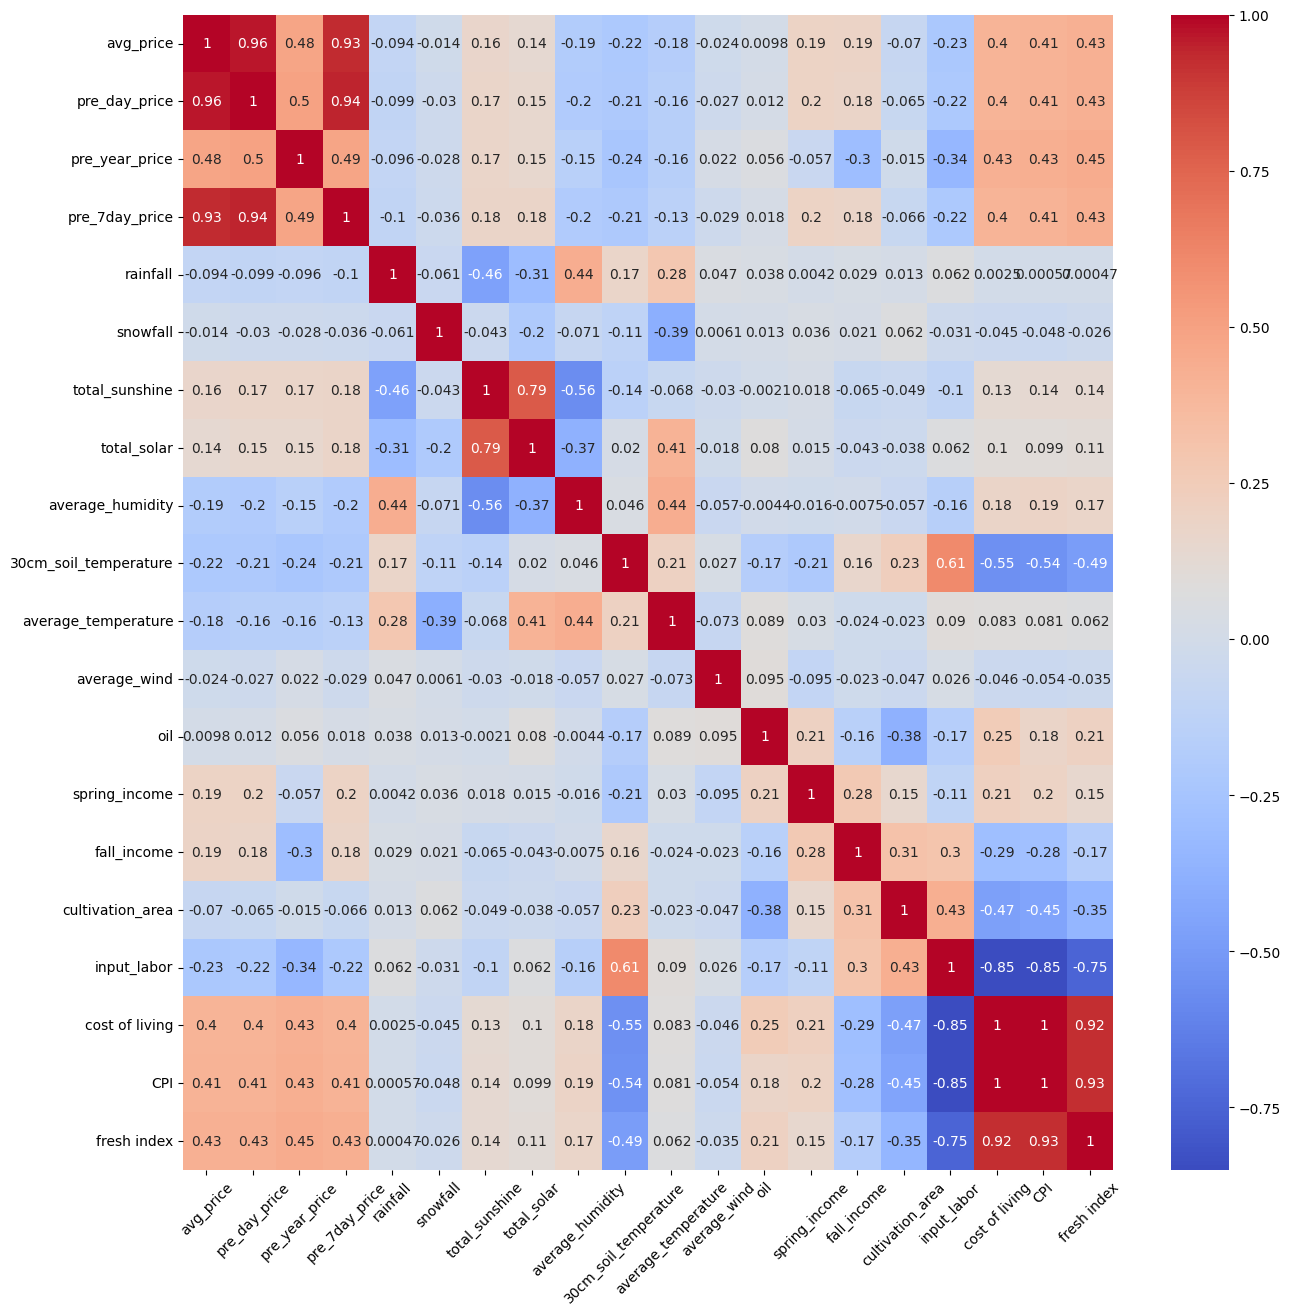

In [5]:
# EDA
# plot the correlation matrix
corr = df.corr()
plt.figure(figsize=(15, 15))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.xticks(rotation=45)
plt.show()


<Figure size 1500x1000 with 0 Axes>

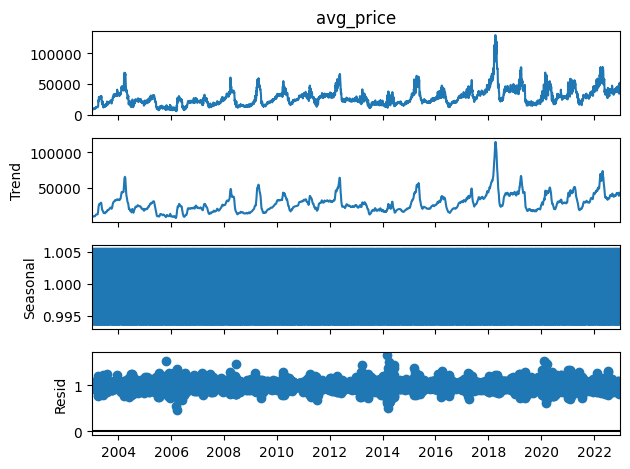

In [6]:
# time series decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# set the date as index
df.set_index("DATE", inplace=True)

# decompose the time series
decomposition = seasonal_decompose(df["avg_price"], model="multiplicative", period=12)
plt.figure(figsize=(15, 10))
decomposition.plot()
plt.show()

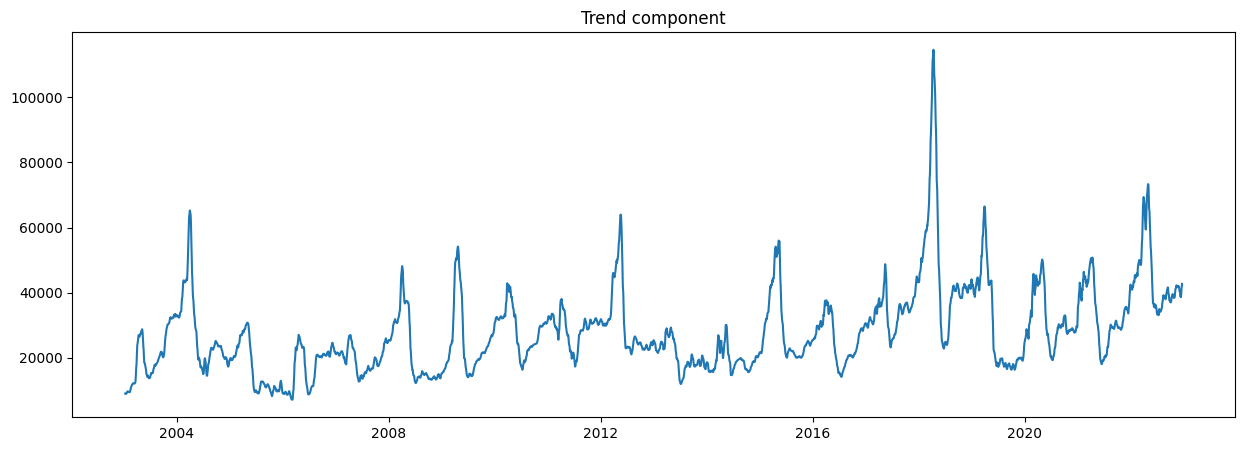

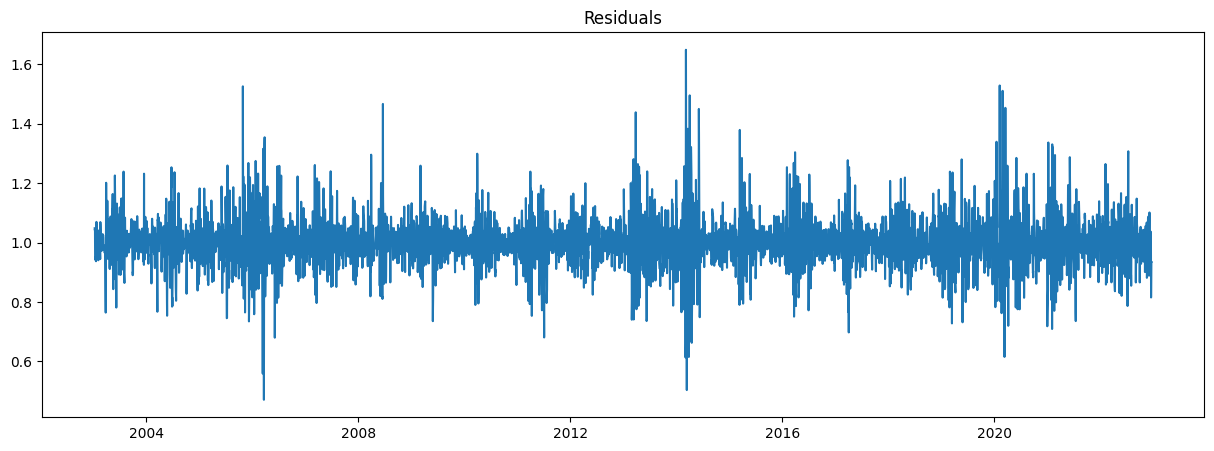

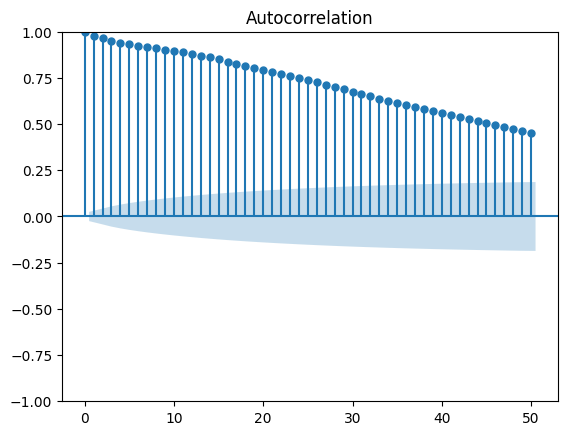

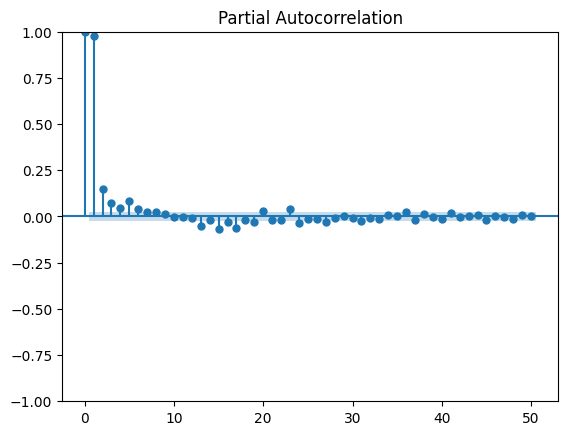

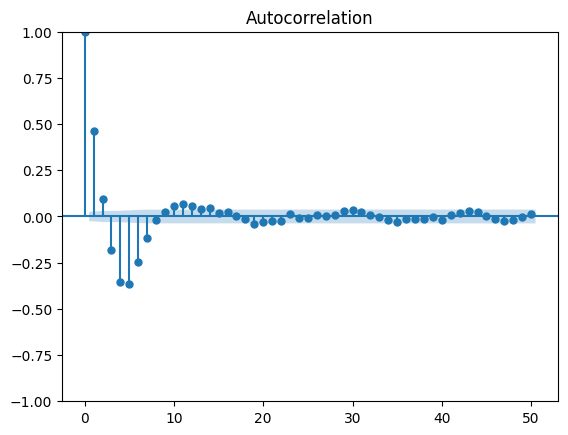

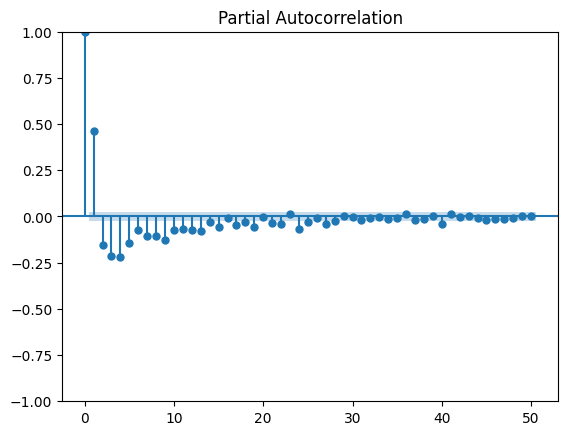

In [7]:
# plot the trend component
plt.figure(figsize=(15, 5))
plt.plot(decomposition.trend)
plt.title("Trend component")
plt.show()

# plot the residuals
plt.figure(figsize=(15, 5))
plt.plot(decomposition.resid)
plt.title("Residuals")
plt.show()

# plot the autocorrelation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df["avg_price"], lags=50)
plt.show()

plot_pacf(df["avg_price"], lags=50)
plt.show()

# plot the autocorrelation of the residuals
plot_acf(decomposition.resid.dropna(), lags=50)
plt.show()

plot_pacf(decomposition.resid.dropna(), lags=50)
plt.show()


ADF Statistic: -6.360044619322819
p-value: True
ADF Statistic: -14.966735670523033
p-value: True


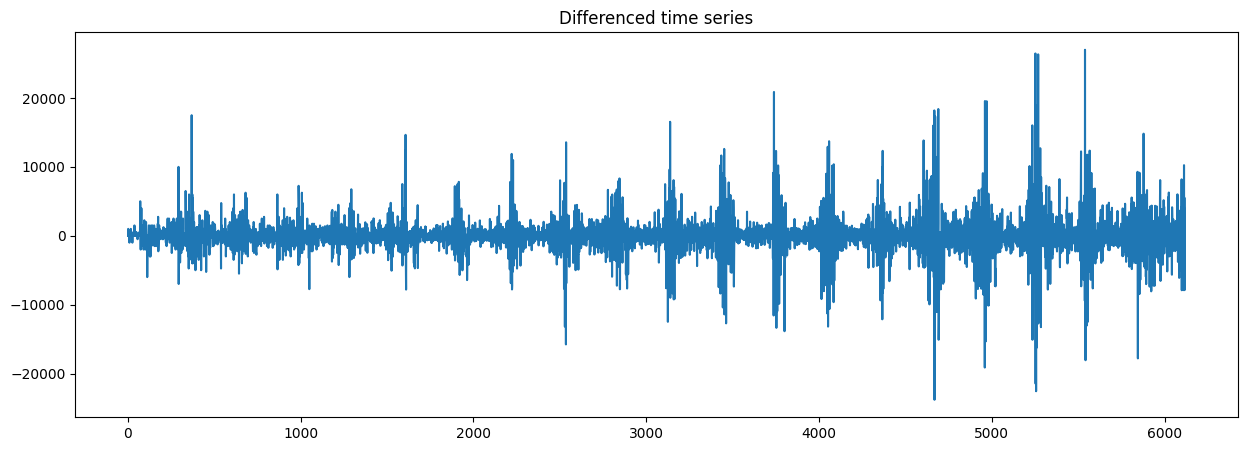

In [256]:
# stationarity test
from statsmodels.tsa.stattools import adfuller

result = adfuller(df["avg_price"])
print("ADF Statistic:", result[0])
print("p-value:", result[1] < 0.05)

# differencing
df["diff"] = df["avg_price"].diff()
result = adfuller(df["diff"].dropna())

print("ADF Statistic:", result[0])
print("p-value:", result[1] < 0.05)

# plot the differenced time series
plt.figure(figsize=(15, 5))
plt.plot(df["diff"])
plt.title("Differenced time series")
plt.show()


In [255]:
# KPSS test
from statsmodels.tsa.stattools import kpss

result = kpss(df["avg_price"])
print("KPSS Statistic:", result[0])
print("p-value:", result[1] < 0.05)

df["diff"] = df["avg_price"].diff()
result = kpss(df["diff"].dropna())

print("KPSS Statistic:", result[0])
print("p-value:", result[1] < 0.05)


KPSS Statistic: 3.063923599064467
p-value: True
KPSS Statistic: 0.007321186491119509
p-value: False


/var/folders/0t/f_9d1d5d2qv03s28lgq_4b7r0000gn/T/ipykernel_41550/1684406165.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(df["avg_price"])
/var/folders/0t/f_9d1d5d2qv03s28lgq_4b7r0000gn/T/ipykernel_41550/1684406165.py:9: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(df["diff"].dropna())


In [290]:
# ARIMA model
from statsmodels.tsa.arima.model import ARIMA

# training set 
train = df["avg_price"].iloc[:-60]

# test set
test = df["avg_price"].iloc[-60:]

# fit the ARIMA model
model = ARIMA(train, order=(1, 1, 1))
model = model.fit()

# coefficients
sigma = model.params[1]
phi = model.params[0]

# residuals
residuals = model.resid

# construct ARIMA model 
preds = []
for i in range(len(train)):
    pred = phi * train[i-1] + sigma * residuals[i-1] + residuals[i]
    preds.append(pred)
    
# to dataframe, index is test data index
preds = pd.Series(preds, index=train.index)
    
# plot the predictions
plt.figure(figsize=(15, 5))
plt.plot(train, label="Train")
plt.plot(preds, label="Predictions")
plt.legend()
plt.show()

# evaluate the model by minimizing the mean squared error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import minmax_scale

# scale the data
train_scaled = minmax_scale(train)
preds_scale = minmax_scale(preds)

arime_mse = mean_squared_error(train_scaled, preds_scale)
print("MSE:", arime_mse)

# plot the residuals
plt.figure(figsize=(15, 5))
plt.plot(train - preds)
plt.title("Residuals")
plt.show()
    

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


KeyError: -1

MSE: 0.04669815066605227


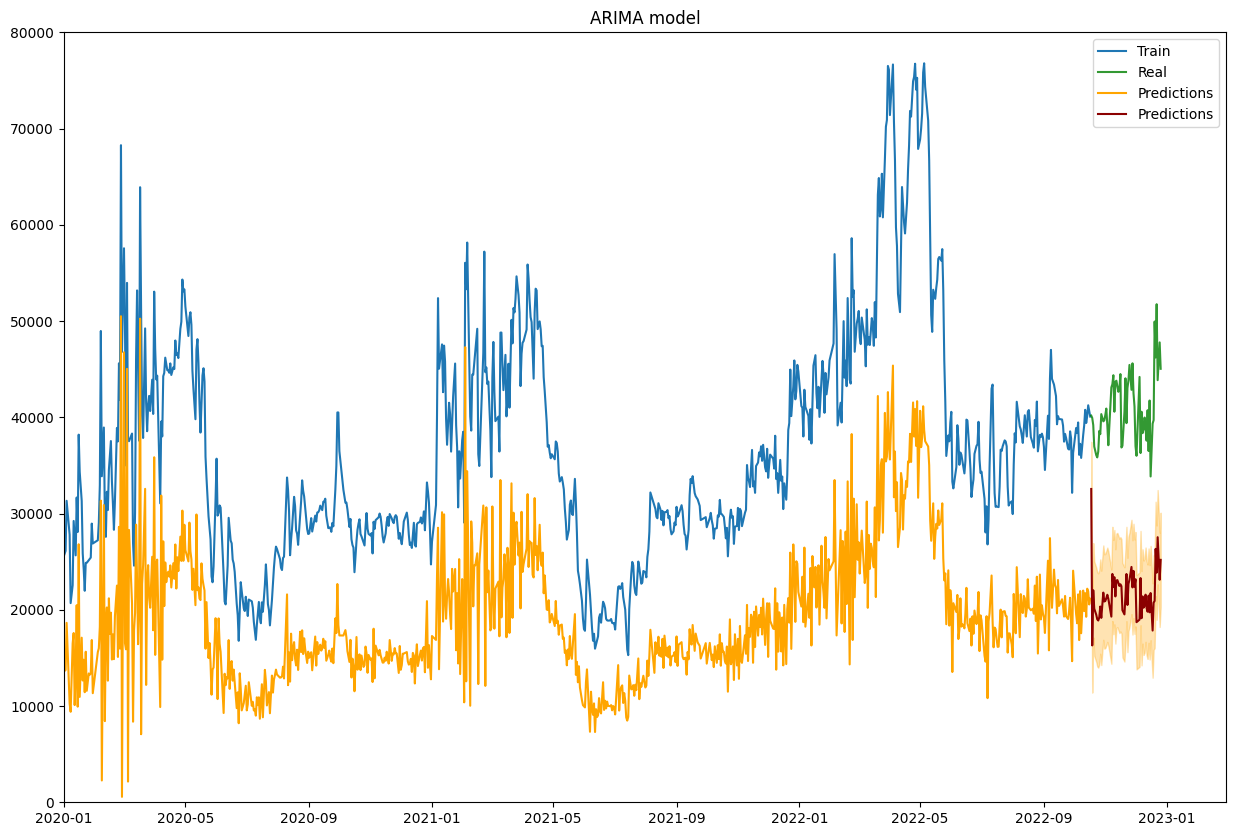

In [11]:
# test the model
real = df["avg_price"].iloc[-60:]

y_pred = []
for i in range(len(test)):
    pred = phi * test[i-1] + sigma * residuals[i-1] + residuals[i]
    y_pred.append(pred)
    
# dataframe with index as test data index
y_pred = pd.Series(y_pred, index=test.index)

# confidence intervals by y_pred +- 1.96 * sigma
sigma_test = sqrt(y_pred.var())
lower = y_pred - 1.96 * sigma_test
upper = y_pred + 1.96 * sigma_test

# evaluate the model
# scale the data
real_scaled = minmax_scale(real)
y_pred_scaled = minmax_scale(y_pred)

mse = mean_squared_error(real_scaled, y_pred_scaled)
print("MSE:", mse)

# plot the predictions
plt.figure(figsize=(15, 10))
plt.plot(train, label="Train")
plt.plot(real, label="Real", color="green", alpha=0.8)
plt.plot(preds, label="Predictions", color="orange")
plt.plot(y_pred, label="Predictions", color="darkred")
plt.fill_between(y_pred.index, lower, upper, color="orange", alpha=0.3)
plt.title("ARIMA model")
plt.xlim("2020-01-01", "2023-03-01")
plt.ylim(0, 80000)
plt.legend()
plt.show()

arima_mes = mse


###  Linear regression

In [12]:
df = pd.read_excel("core_data.xlsx")

# replace missing values with 0
df.fillna(0, inplace=True)

# target variable
y = df["avg_price"]

# features
X = df.drop(columns=["avg_price", "DATE", "pre_day_price", "pre_year_price", "pre_7day_price"])

# forward selection
variables = X.columns.tolist()

selected_variables = []
sl_enter = 0.05
sv_per_step = []
adjusted_r_squared = []  
steps = []
step = 0

while len(variables) > 0:
    remainder = list(set(variables) - set(selected_variables))
    pval = pd.Series(index=remainder)
    
    for col in remainder:
        X_temp = X[selected_variables + [col]]
        X_temp = sm.add_constant(X_temp)
        model = sm.OLS(y, X_temp).fit()
        pval[col] = model.pvalues[col]
        
    min_pval = pval.min()
    if min_pval < sl_enter:
        selected_variables.append(pval.idxmin())
        
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(y, sm.add_constant(X[selected_variables])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
    
    else:
        break
            
        
    




/var/folders/0t/f_9d1d5d2qv03s28lgq_4b7r0000gn/T/ipykernel_41550/1918958600.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pval = pd.Series(index=remainder)
/var/folders/0t/f_9d1d5d2qv03s28lgq_4b7r0000gn/T/ipykernel_41550/1918958600.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pval = pd.Series(index=remainder)
/var/folders/0t/f_9d1d5d2qv03s28lgq_4b7r0000gn/T/ipykernel_41550/1918958600.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pval = pd.Series(index=remainder)
/var/folders/0t/f_9d1d5d2qv03s28lgq_4b7r0000gn/T/ipykernel_41550/1918958600.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of

In [282]:
X_train

,rainfall,total_sunshine,total_solar,average_humidity,30cm_soil_temperature,cost of living,CPI,fresh index
0,0.000,7.450,9.320000,44.00,0.00,66.397,68.391,52.246
1,2.625,1.425,3.890000,53.00,0.00,66.397,68.391,52.246
2,2.275,3.400,5.013333,68.00,0.00,66.397,68.391,52.246
3,0.000,8.350,9.966667,66.00,0.00,66.397,68.391,52.246
4,0.000,8.450,10.496667,47.00,0.00,66.397,68.391,52.246
...,...,...,...,...,...,...,...,...
4883,2.075,0.000,2.266667,63.75,12.60,99.725,99.462,102.745
4884,0.000,8.740,9.843333,58.25,14.75,99.725,99.462,102.745
4885,0.660,4.600,6.783333,68.75,14.50,99.725,99.462,102.745
4886,0.000,8.600,11.480000,63.25,14.25,99.725,99.462,102.745


In [286]:
# select the optimal variables ---------------------

# target variable
y = df["avg_price"]

# features
X = df[selected_variables].drop(columns=["avg_price"])

# min-max scaling
from sklearn.preprocessing import MinMaxScaler

#scaler = MinMaxScaler()
#X = scaler.fit_transform(X)
#Y = scaler.fit_transform(y.values.reshape(-1, 1))

X_train, y_train = X[:4885], y[:4885]
X_test, y_test = X[4885:], y[4885:]


# linear regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

y_pred_minmax = MinMaxScaler().fit_transform(y_pred.values.reshape(-1, 1))
y_test_minmax = MinMaxScaler().fit_transform(y_test.values.reshape(-1, 1))

mse = mean_squared_error(y_test_minmax, y_pred_minmax)

print("MSE:", mse)


/var/folders/0t/f_9d1d5d2qv03s28lgq_4b7r0000gn/T/ipykernel_41550/46128039.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  X_train, y_train = X[:4885], y[:4885]
/var/folders/0t/f_9d1d5d2qv03s28lgq_4b7r0000gn/T/ipykernel_41550/46128039.py:17: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  X_test, y_test = X[4885:], y[4885:]


AttributeError: 'numpy.ndarray' object has no attribute 'values'

### VAR model

In [47]:
# drop date column and pre_day_price column
df.drop(columns=["DATE", "pre_day_price", "pre_year_price", "pre_7day_price"], inplace=True)

,DATE,avg_price,pre_day_price,pre_year_price,pre_7day_price,rainfall,snowfall,total_sunshine,total_solar,average_humidity,...,average_temperature,average_wind,oil,spring_income,fall_income,cultivation_area,input_labor,cost of living,CPI,fresh index
0,2003-01-01,8500.0,8500,9000,9000,0.000,6.100000,7.450,9.320000,44.0,...,-3.20,0.8,31.20,873395,1330346,557723,72.8,66.397,68.391,52.246
1,2003-01-03,8500.0,8500,9000,8000,2.625,5.625000,1.425,3.890000,53.0,...,-1.75,0.6,33.08,873395,1330346,557723,72.8,66.397,68.391,52.246
2,2003-01-04,9500.0,8500,9000,8000,2.275,11.466667,3.400,5.013333,68.0,...,-7.75,1.1,33.08,873395,1330346,557723,72.8,66.397,68.391,52.246
3,2003-01-07,9500.0,8500,9000,8000,0.000,6.166667,8.350,9.966667,66.0,...,-6.50,0.2,31.08,873395,1330346,557723,72.8,66.397,68.391,52.246
4,2003-01-08,9500.0,8500,9000,8500,0.000,6.300000,8.450,10.496667,47.0,...,-4.60,0.3,30.56,873395,1330346,557723,72.8,66.397,68.391,52.246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6113,2022-12-21,46216.0,49948,34036,41742,4.580,3.300000,0.220,1.372500,86.0,...,-0.02,0.0,78.24,1073955,990686,511857,45.0,110.750,108.730,113.560
6114,2022-12-22,51748.0,46216,38684,33850,2.150,4.900000,4.740,7.697500,64.8,...,-6.00,0.0,77.42,1073955,990686,511857,45.0,110.750,108.730,113.560
6115,2022-12-23,43856.0,51748,39406,38988,2.650,6.433333,5.420,8.047500,65.2,...,-9.60,2.2,79.64,1073955,990686,511857,45.0,110.750,108.730,113.560
6116,2022-12-25,47781.0,50525,40123,39701,0.000,2.866667,7.760,10.917500,77.6,...,-7.38,0.0,79.64,1073955,990686,511857,45.0,110.750,108.730,113.560


In [51]:
# Granger
"""Granger 인과검정의 영가설은 'X가 Y에 영향을 미치지 않는다' 이다. 즉, 검정 결과 p_value가 유의수준 0.05 이하라면 영가설을 기각하고 해당 변수를 예측모델의 인자로 사용"""
from statsmodels.tsa.stattools import grangercausalitytests
gr_df = df.copy()
gr_df.drop(columns=["DATE", "pre_day_price", "pre_year_price", "pre_7day_price"], inplace=True)
gr_df['avg_price'].diff()

df_pairs = pd.DataFrame(data=np.zeros((len(gr_df.columns), len(gr_df.columns))),
                        columns = ['X_'+x for x in gr_df.columns],
                        index = ['Y_'+x for x in gr_df.columns])


# create a dataframe with the p-values
maxlag = 7

for col_i, col in enumerate(gr_df):
    for idx_i, idx in enumerate(gr_df):
        outs = grangercausalitytests(gr_df[[col,idx]], maxlag=maxlag)
        pval_min = np.min([round(outs[x][0]['ssr_chi2test'][1],2) for x in range(1, maxlag+1)])
        df_pairs.iloc[idx_i, col_i] = pval_min


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=-0.0000 , p=1.0000  , df_denom=6114, df_num=1
ssr based chi2 test:   chi2=-0.0000 , p=1.0000  , df=1
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=1
parameter F test:         F=141281.9615, p=0.0000  , df_denom=6114, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=-0.0000 , p=1.0000  , df_denom=6113, df_num=2
ssr based chi2 test:   chi2=-0.0000 , p=1.0000  , df=2
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=2
parameter F test:         F=72345.6996, p=0.0000  , df_denom=6113, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=-0.0000 , p=1.0000  , df_denom=6111, df_num=3
ssr based chi2 test:   chi2=-0.0000 , p=1.0000  , df=3
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=3
parameter F test:         F=48459.1219, p=0.0000  , df_denom=6111, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=-0.0000

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 2
  warnings.warn('covariance of constraints does not have full '


ssr based F test:         F=55.5499 , p=0.0000  , df_denom=6114, df_num=1
ssr based chi2 test:   chi2=55.5772 , p=0.0000  , df=1
likelihood ratio test: chi2=55.3262 , p=0.0000  , df=1
parameter F test:         F=55.5499 , p=0.0000  , df_denom=6114, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=35.7150 , p=0.0000  , df_denom=6111, df_num=2
ssr based chi2 test:   chi2=71.4884 , p=0.0000  , df=2
likelihood ratio test: chi2=71.0738 , p=0.0000  , df=2
parameter F test:         F=35.7150 , p=0.0000  , df_denom=6111, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=27.4932 , p=0.0000  , df_denom=6108, df_num=3
ssr based chi2 test:   chi2=82.5742 , p=0.0000  , df=3
likelihood ratio test: chi2=82.0217 , p=0.0000  , df=3
parameter F test:         F=27.4932 , p=0.0000  , df_denom=6108, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=21.0460 , p=0.0000  , df_denom=6105, df_num=4
ssr based chi2

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of

ssr based F test:         F=-0.0385 , p=1.0000  , df_denom=6110, df_num=3
ssr based chi2 test:   chi2=-0.1157 , p=1.0000  , df=3
likelihood ratio test: chi2=-0.1157 , p=1.0000  , df=3
parameter F test:         F=0.0309  , p=0.8605  , df_denom=6110, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=-0.0034 , p=1.0000  , df_denom=6108, df_num=4
ssr based chi2 test:   chi2=-0.0134 , p=1.0000  , df=4
likelihood ratio test: chi2=-0.0134 , p=1.0000  , df=4
parameter F test:         F=0.0257  , p=0.8725  , df_denom=6108, df_num=1

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=-1.1010 , p=1.0000  , df_denom=6106, df_num=5
ssr based chi2 test:   chi2=-5.5116 , p=1.0000  , df=5
likelihood ratio test: chi2=-5.5140 , p=1.0000  , df=5
parameter F test:         F=0.0255  , p=0.8731  , df_denom=6106, df_num=1

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=-0.3761 , p=1.0000  , df_denom=6104, df_num=6
ssr based chi2

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  warnings.warn('covariance of constraints does not have full '


likelihood ratio test: chi2=11.6480 , p=0.0087  , df=3
parameter F test:         F=3.8819  , p=0.0087  , df_denom=6108, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.8628  , p=0.0220  , df_denom=6105, df_num=4
ssr based chi2 test:   chi2=11.4679 , p=0.0218  , df=4
likelihood ratio test: chi2=11.4572 , p=0.0219  , df=4
parameter F test:         F=2.8628  , p=0.0220  , df_denom=6105, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.3525  , p=0.0383  , df_denom=6102, df_num=5
ssr based chi2 test:   chi2=11.7838 , p=0.0379  , df=5
likelihood ratio test: chi2=11.7725 , p=0.0380  , df=5
parameter F test:         F=2.3525  , p=0.0383  , df_denom=6102, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.1391  , p=0.0459  , df_denom=6099, df_num=6
ssr based chi2 test:   chi2=12.8621 , p=0.0453  , df=6
likelihood ratio test: chi2=12.8486 , p=0.0455  , df=6
parameter F test:         F=2.139

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  warnings.warn('covariance of constraints does not have full '


ssr based F test:         F=0.5651  , p=0.6380  , df_denom=6108, df_num=3
ssr based chi2 test:   chi2=1.6971  , p=0.6376  , df=3
likelihood ratio test: chi2=1.6969  , p=0.6376  , df=3
parameter F test:         F=0.5651  , p=0.6380  , df_denom=6108, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.5693  , p=0.6849  , df_denom=6105, df_num=4
ssr based chi2 test:   chi2=2.2807  , p=0.6843  , df=4
likelihood ratio test: chi2=2.2803  , p=0.6844  , df=4
parameter F test:         F=0.5693  , p=0.6849  , df_denom=6105, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.5429  , p=0.7439  , df_denom=6102, df_num=5
ssr based chi2 test:   chi2=2.7194  , p=0.7432  , df=5
likelihood ratio test: chi2=2.7188  , p=0.7432  , df=5
parameter F test:         F=0.5429  , p=0.7439  , df_denom=6102, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.5410  , p=0.7774  , df_denom=6099, df_num=6
ssr based chi2

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of

parameter F test:         F=0.0002  , p=1.0000  , df_denom=6102, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.0002  , p=1.0000  , df_denom=6099, df_num=6
ssr based chi2 test:   chi2=0.0012  , p=1.0000  , df=6
likelihood ratio test: chi2=0.0012  , p=1.0000  , df=6
parameter F test:         F=0.0002  , p=1.0000  , df_denom=6099, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.0002  , p=1.0000  , df_denom=6096, df_num=7
ssr based chi2 test:   chi2=0.0015  , p=1.0000  , df=7
likelihood ratio test: chi2=0.0015  , p=1.0000  , df=7
parameter F test:         F=0.0002  , p=1.0000  , df_denom=6096, df_num=7

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7974  , p=0.3719  , df_denom=6114, df_num=1
ssr based chi2 test:   chi2=0.7978  , p=0.3718  , df=1
likelihood ratio test: chi2=0.7978  , p=0.3718  , df=1
parameter F test:         F=0.7974  , p=0.3719  , df_denom=6114, df_num=1

Granger Causa

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of

parameter F test:         F=0.0027  , p=0.9586  , df_denom=6108, df_num=1

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=-118.3669, p=1.0000  , df_denom=6106, df_num=5
ssr based chi2 test:   chi2=-592.5131, p=1.0000  , df=5
likelihood ratio test: chi2=-623.2301, p=1.0000  , df=5
parameter F test:         F=0.0030  , p=0.9567  , df_denom=6106, df_num=1

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=-453.5999, p=1.0000  , df_denom=6104, df_num=6
ssr based chi2 test:   chi2=-2725.1664, p=1.0000  , df=6
likelihood ratio test: chi2=-3608.2718, p=1.0000  , df=6
parameter F test:         F=0.0019  , p=0.9653  , df_denom=6104, df_num=1

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=-16.6043, p=1.0000  , df_denom=6102, df_num=7
ssr based chi2 test:   chi2=-116.4013, p=1.0000  , df=7
likelihood ratio test: chi2=-117.5242, p=1.0000  , df=7
parameter F test:         F=0.0033  , p=0.9543  , df_denom=6102, df_num=1

Gra

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of

ssr based F test:         F=0.6378  , p=0.5906  , df_denom=6108, df_num=3
ssr based chi2 test:   chi2=1.9156  , p=0.5901  , df=3
likelihood ratio test: chi2=1.9153  , p=0.5902  , df=3
parameter F test:         F=0.6378  , p=0.5906  , df_denom=6108, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.4794  , p=0.7509  , df_denom=6105, df_num=4
ssr based chi2 test:   chi2=1.9203  , p=0.7504  , df=4
likelihood ratio test: chi2=1.9200  , p=0.7505  , df=4
parameter F test:         F=0.4794  , p=0.7509  , df_denom=6105, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.3843  , p=0.8599  , df_denom=6102, df_num=5
ssr based chi2 test:   chi2=1.9251  , p=0.8594  , df=5
likelihood ratio test: chi2=1.9248  , p=0.8595  , df=5
parameter F test:         F=0.3843  , p=0.8599  , df_denom=6102, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.3210  , p=0.9264  , df_denom=6099, df_num=6
ssr based chi2

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 6, but rank is 1
  warnings.warn('covariance of constraints does not have full '


parameter F test:         F=7.4861  , p=0.0000  , df_denom=6102, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=6.4732  , p=0.0000  , df_denom=6099, df_num=6
ssr based chi2 test:   chi2=38.9218 , p=0.0000  , df=6
likelihood ratio test: chi2=38.7984 , p=0.0000  , df=6
parameter F test:         F=6.4732  , p=0.0000  , df_denom=6099, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=6.8156  , p=0.0000  , df_denom=6096, df_num=7
ssr based chi2 test:   chi2=47.8263 , p=0.0000  , df=7
likelihood ratio test: chi2=47.6402 , p=0.0000  , df=7
parameter F test:         F=6.8156  , p=0.0000  , df_denom=6096, df_num=7

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=26.7534 , p=0.0000  , df_denom=6114, df_num=1
ssr based chi2 test:   chi2=26.7666 , p=0.0000  , df=1
likelihood ratio test: chi2=26.7082 , p=0.0000  , df=1
parameter F test:         F=26.7534 , p=0.0000  , df_denom=6114, df_num=1

Granger Causa

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of

ssr based F test:         F=-1503.5798, p=1.0000  , df_denom=6108, df_num=4
ssr based chi2 test:   chi2=-6020.2273, p=1.0000  , df=4
likelihood ratio test: chi2=-25541.0046, p=1.0000  , df=4
parameter F test:         F=0.0001  , p=0.9903  , df_denom=6108, df_num=1

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=-1172.1364, p=1.0000  , df_denom=6106, df_num=5
ssr based chi2 test:   chi2=-5867.4007, p=1.0000  , df=5
likelihood ratio test: chi2=-19650.0641, p=1.0000  , df=5
parameter F test:         F=0.0004  , p=0.9847  , df_denom=6106, df_num=1

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=-976.0603, p=1.0000  , df_denom=6104, df_num=6
ssr based chi2 test:   chi2=-5864.0374, p=1.0000  , df=6
likelihood ratio test: chi2=-19587.3180, p=1.0000  , df=6
parameter F test:         F=0.0004  , p=0.9848  , df_denom=6104, df_num=1

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=-794.2505, p=1.0000  , df_denom=6102, df

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of

ssr based F test:         F=7.4479  , p=0.0064  , df_denom=6114, df_num=1
ssr based chi2 test:   chi2=7.4516  , p=0.0063  , df=1
likelihood ratio test: chi2=7.4470  , p=0.0064  , df=1
parameter F test:         F=7.4479  , p=0.0064  , df_denom=6114, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.7970  , p=0.0083  , df_denom=6111, df_num=2
ssr based chi2 test:   chi2=9.6019  , p=0.0082  , df=2
likelihood ratio test: chi2=9.5943  , p=0.0083  , df=2
parameter F test:         F=4.7970  , p=0.0083  , df_denom=6111, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.2600  , p=0.0206  , df_denom=6108, df_num=3
ssr based chi2 test:   chi2=9.7911  , p=0.0204  , df=3
likelihood ratio test: chi2=9.7832  , p=0.0205  , df=3
parameter F test:         F=3.2600  , p=0.0206  , df_denom=6108, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.6736  , p=0.0303  , df_denom=6105, df_num=4
ssr based chi2

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of

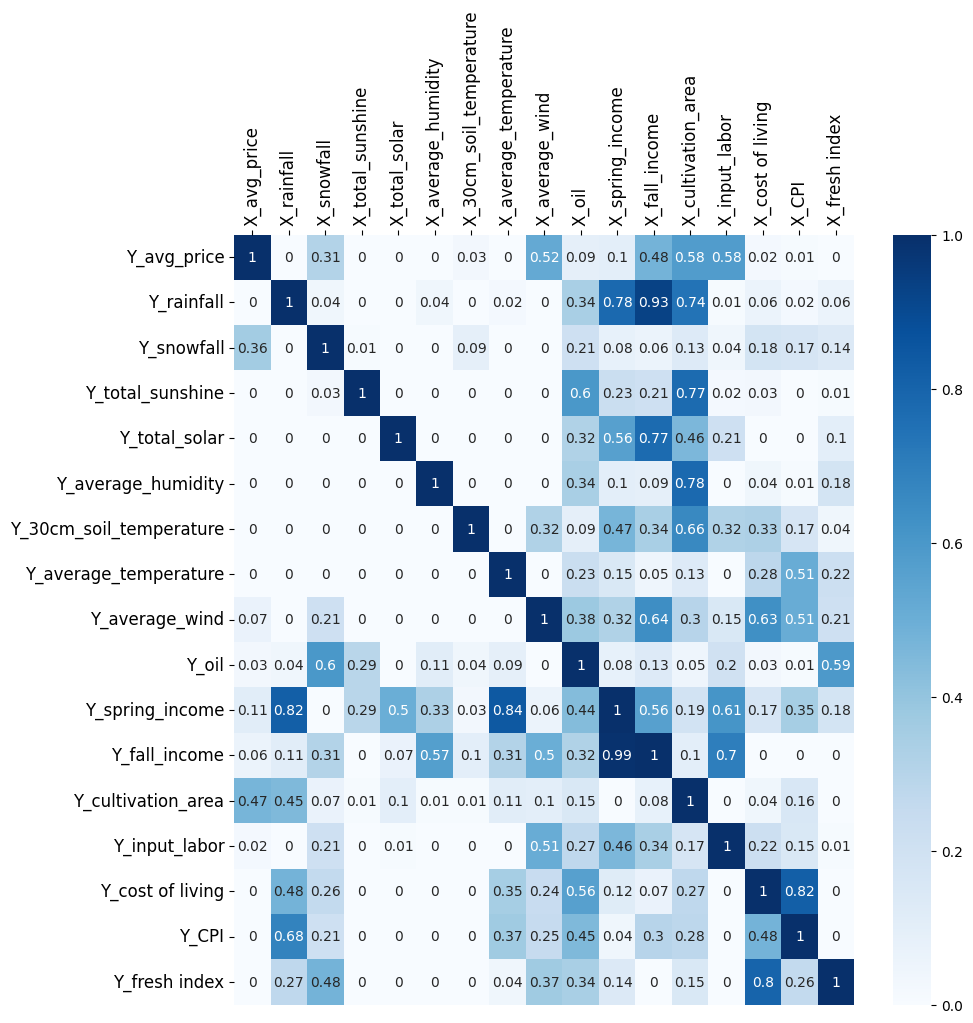

In [66]:
plt.figure(figsize=(10, 10))
ax = sns.heatmap(df_pairs, annot=True, cmap='Blues')
ax.xaxis.tick_top()
plt.xticks(fontsize=12, rotation=90) 
plt.yticks(fontsize=12)
plt.show()

selected_variables = ["avg_price", "rainfall", "total_sunshine", "total_solar", "average_humidity", "30cm_soil_temperature",
                      "cost of living", "CPI", "fresh index"]


In [74]:
# Cointegration Test
""" 시계열의 공적분 관계를 검증 공적분 결과값이 해당 유의수준 통계량보다 크다면(우측, 단측검정) 유의하다. 즉, 장기적으로 안정적인 연관성이 있다고 판단 """
from statsmodels.tsa.vector_ar.vecm import coint_johansen


def calc_sig_dist(cols):
    out = coint_johansen(df[cols], 1, 1)
    stats = [round(x,2) for x in out.lr1]
    sigs = [round(x,2) for x in out.cvt[:, 1]]
    yns = [x>y for x,y in zip(stats,sigs)]
    dist = np.mean(np.array(stats) - np.array(sigs))
    

    print('stats: ',stats)
    print('sig-level: ',sigs)
    print('significant_yn: ',[x>y for x,y in zip(stats,sigs)])
    print('dist: ', round(dist,2))

calc_sig_dist(selected_variables) # 공적분 관계 없음

stats:  [5474.53, 3372.58, 1443.19, 425.26, 221.68, 125.66, 52.35, 18.67, 5.75]
sig-level:  [215.13, 175.16, 139.28, 107.34, 79.34, 55.25, 35.01, 18.4, 3.84]
significant_yn:  [True, True, True, True, True, True, True, True, True]
dist:  1145.66


True

In [144]:
# ADF Test
from statsmodels.tsa.stattools import adfuller
"""영가설은 정상성을 띄지 않는다 이다. ADF는 추세를 포함하는 시계열 데이터에 대해서도 단위근 검정을 실시해주는 방법론"""
def adf_test(cols):
    for col in cols:
        result = adfuller(df[col],  autolag='AIC')
        print(f'ADF Statistic for {col}: {result[0]}')
        print(result[1] < 0.05)
        print('---------------------------------------')

adf_test(selected_variables)

# 1st difference
required_diff = ["cost of living", "CPI", "fresh index"]
first_diff = df[required_diff].diff().dropna()

for col in required_diff:
    result = adfuller(first_diff[col],  autolag='AIC')
    print(f'ADF Statistic for {col}: {result[0]}')
    print(result[1] < 0.05)
    print('---------------------------------------')


ADF Statistic for avg_price: -6.605687560081809
True
---------------------------------------
ADF Statistic for rainfall: -9.281800523099438
True
---------------------------------------
ADF Statistic for total_sunshine: -12.899308166354166
True
---------------------------------------
ADF Statistic for total_solar: -7.240732670235306
True
---------------------------------------
ADF Statistic for average_humidity: -6.7957171743413385
True
---------------------------------------
ADF Statistic for 30cm_soil_temperature: -5.9714163807593215
True
---------------------------------------
ADF Statistic for cost of living: -0.7638250512285975
False
---------------------------------------
ADF Statistic for CPI: -0.36534441990774225
False
---------------------------------------
ADF Statistic for fresh index: -2.228142659536714
False
---------------------------------------
ADF Statistic for cost of living: -11.133349002870162
True
---------------------------------------
ADF Statistic for CPI: -10.87

In [152]:
# VAR model
from statsmodels.tsa.api import VAR

# features
X = df[selected_variables]
X[required_diff] = X[required_diff].diff().dropna()
X = X.dropna()


# split data
train_size = int(len(X) * 0.8)
train, test = X[0:train_size], X[train_size:]

# fit the model
#model = VAR(train)
#model.select_order(maxlags=30).summary()


# scaling data
"""측값이 최근 일자, 관측값이 과거 일자이므로 정규화가 최근 일자 예측에 어떠한 영향도 미쳐선 안된다. 예를 들어, 전체 데이터를 min-max-scailing한다거나 하는 식으로 말이다."""

df_train_norm = (train / train.iloc[0]) - 1
df_train_norm[required_diff] = train[required_diff]
df_train_norm["30cm_soil_temperature"] = (train["30cm_soil_temperature"] / 1) - 1

# adf test
for col in df_train_norm.columns:
    result = adfuller(df_train_norm[col],  autolag='AIC')
    print(f'ADF Statistic for {col}: {result[0]}')
    print(result[1] < 0.05)
    print('---------------------------------------')


"""일반적으로 AIC 기준 2.0 이하는 모델이 타당. 모델은 과거 1주일치 데이터만 가지고도 어느 정도의 성능을 보이고 있으며, 예측 정확도는 2주 데이터가 확보되었을 때 가장 높았다.따라서 모델의 시차(lag)를 2주로 적합시킨다.
"""



/var/folders/0t/f_9d1d5d2qv03s28lgq_4b7r0000gn/T/ipykernel_41550/3962945266.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[required_diff] = X[required_diff].diff().dropna()


ADF Statistic for avg_price: -6.239469521678498
True
---------------------------------------
ADF Statistic for rainfall: -8.109360793528497
True
---------------------------------------
ADF Statistic for total_sunshine: -11.595791562725612
True
---------------------------------------
ADF Statistic for total_solar: -5.663677844150155
True
---------------------------------------
ADF Statistic for average_humidity: -6.5589835112719275
True
---------------------------------------
ADF Statistic for 30cm_soil_temperature: -5.487912839984069
True
---------------------------------------
ADF Statistic for cost of living: -9.90258435735902
True
---------------------------------------
ADF Statistic for CPI: -10.115174524996865
True
---------------------------------------
ADF Statistic for fresh index: -10.520945847828333
True
---------------------------------------


'일반적으로 AIC 기준 2.0 이하는 모델이 타당. 모델은 과거 1주일치 데이터만 가지고도 어느 정도의 성능을 보이고 있으며, 예측 정확도는 2주 데이터가 확보되었을 때 가장 높았다.따라서 모델의 시차(lag)를 2주로 적합시킨다.\n'

In [156]:
# fit the model
model = VAR(df_train_norm)
model.select_order(maxlags=30).summary()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,-6.985,-6.973,0.0009256,-6.981
1,-15.38,-15.26,2.097e-07,-15.34
2,-15.68,-15.45,1.553e-07,-15.60
3,-15.82,-15.49*,1.344e-07,-15.70
4,-15.87,-15.43,1.278e-07,-15.72*
5,-15.89,-15.34,1.256e-07,-15.70
6,-15.90,-15.24,1.240e-07,-15.67
7,-15.93*,-15.16,1.211e-07*,-15.66
8,-15.93,-15.05,1.212e-07,-15.62
9,-15.92,-14.94,1.214e-07,-15.58


In [159]:
# fit the model by lag 7
model_fitted = model.fit(7)
model_fitted.summary()


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 17, Nov, 2024
Time:                     19:11:07
--------------------------------------------------------------------
No. of Equations:         9.00000    BIC:                   -15.1732
Nobs:                     4886.00    HQIC:                  -15.6701
Log likelihood:          -22882.0    FPE:                1.19644e-07
AIC:                     -15.9388    Det(Omega_mle):     1.06420e-07
--------------------------------------------------------------------
Results for equation avg_price
                              coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------
const                            0.081089         0.021961            3.692           0.000
L1.avg_price                     0.856831         0.014387           59.556           0.000
L1.rainfall 

In [163]:
# independence of residuals test
from statsmodels.stats.stattools import durbin_watson

durbin_res = pd.DataFrame([model_fitted.resid.columns, 
                           [round(x,2) for x in durbin_watson(model_fitted.resid)]]).T
durbin_res.set_index([0])

# 2에 수렴하므로 독립성 만족



,1
0,
avg_price,1.99
rainfall,2.0
total_sunshine,2.0
total_solar,2.0
average_humidity,2.0
30cm_soil_temperature,2.01
cost of living,2.0
CPI,2.0
fresh index,2.0


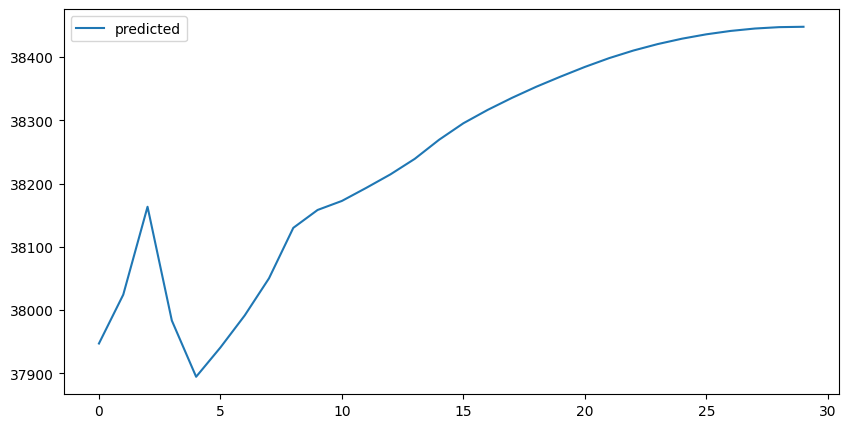

/var/folders/0t/f_9d1d5d2qv03s28lgq_4b7r0000gn/T/ipykernel_41550/4065970981.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(test["avg_price"][:30], label='actual')


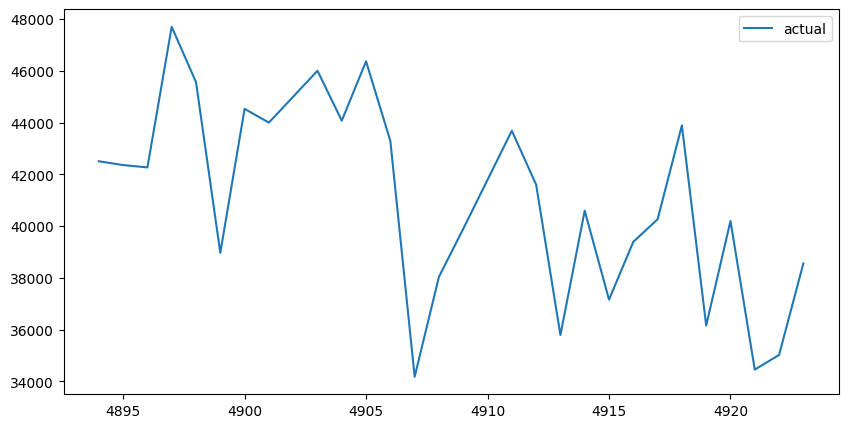

In [193]:
# forecast
ins = df_train_norm.values[-7:]
fc = model_fitted.forecast(y=ins, steps=30)
df_fc = pd.DataFrame(fc, columns=df_train_norm.columns)

# inverse scaling
df_denorm = (df_fc + 1).mul(train.iloc[0].to_numpy()) 

# plot forecast result of avg_price
plt.figure(figsize=(10, 5))
plt.plot(df_denorm["avg_price"], label='predicted')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(test["avg_price"][:30], label='actual')
plt.legend()
plt.show()




In [194]:
# evaluation
from sklearn.metrics import mean_squared_error

# after scaling min-max 
from sklearn.preprocessing import MinMaxScaler
pred_minmax = MinMaxScaler().fit_transform(df_denorm["avg_price"].values.reshape(-1,1))
test_minmax = MinMaxScaler().fit_transform(test["avg_price"][:30].values.reshape(-1,1))

# mse
VAR_mse = mean_squared_error(test_minmax, pred_minmax)
print(f'MSE of VAR model: {VAR_mse}')


MSE of VAR model: 0.2925121818972135


/var/folders/0t/f_9d1d5d2qv03s28lgq_4b7r0000gn/T/ipykernel_41550/1514719207.py:7: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  test_minmax = MinMaxScaler().fit_transform(test["avg_price"][:30].values.reshape(-1,1))


0        8500.0
1        8500.0
2        9500.0
3        9500.0
4        9500.0
         ...   
4890    39109.0
4891    37109.0
4892    36750.0
4893    37594.0
4894    42503.5
Name: avg_price, Length: 4895, dtype: float64

In [1]:
# ensamble model with lasso, ridge, linear regression
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.ensemble import VotingRegressor

lasso = Lasso(alpha=0.1)
ridge = Ridge(alpha=0.1) 
lr = LinearRegression() 

# split data with 1223 data
x_train, y_train = X[:4895], y[:4895]
x_test, y_test = X[4895:], y[4895:]

# fit the model
lasso.fit(x_train, y_train)
ridge.fit(x_train, y_train) 
lr.fit(x_train, y_train)

# predict 
lasso_pred = lasso.predict(x_test) 
ridge_pred = ridge.predict(x_test) 
lr_pred = lr.predict(x_test) 

# ensemble model 
ensemble = VotingRegressor(estimators=[('lasso', lasso), ('ridge', ridge), ('lr', lr)]) 
ensemble.fit(x_train, y_train) 
ensemble_pred = ensemble.predict(x_test) 

# scaling min-max
test_t_scaled = MinMaxScaler().fit_transform(y_test.values.reshape(-1,1))
ensemble_pred_scaled = MinMaxScaler().fit_transform(ensemble_pred.reshape(-1,1))

# mse
ensemble_mse = mean_squared_error(test_t_scaled, ensemble_pred_scaled)
print(f'MSE of ensemble model: {ensemble_mse}')

# plot by ensemble model and actual
plt.figure(figsize=(10, 5)) 
plt.plot(ensemble_pred, label='predicted')
plt.plot(y_test, label='actual')
plt.legend()
plt.show()




NameError: name 'X' is not defined

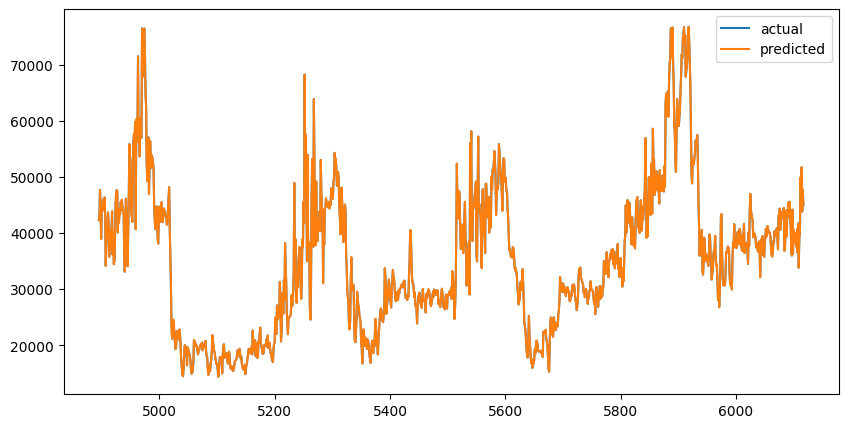

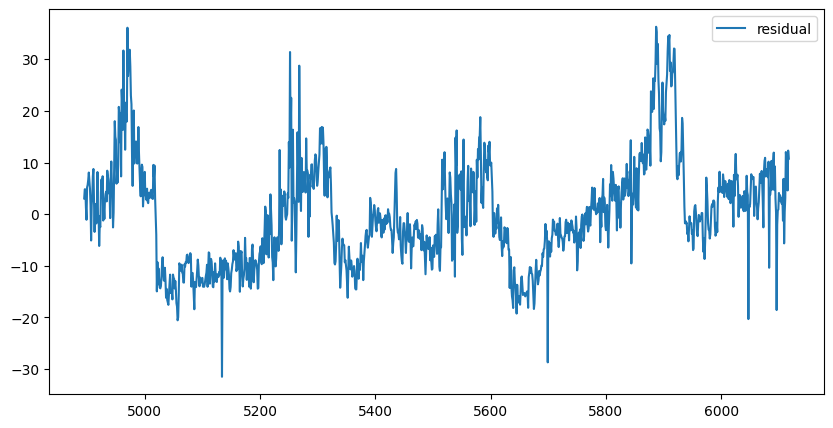

In [226]:
# create dataframe for prediction and actual
df_pred = pd.DataFrame({'date': y_test.index, 'actual': y_test, 'ensemble': ensemble_pred,
                        "residual": y_test - ensemble_pred})

# plot
plt.figure(figsize=(10, 5))
plt.plot(df_pred['date'], df_pred['actual'], label='actual') 
plt.plot(df_pred['date'], df_pred['ensemble'], label='predicted')
plt.legend()
plt.show() 

# plot residual
plt.figure(figsize=(10, 5))
plt.plot(df_pred['date'], df_pred['residual'], label='residual') 
plt.legend() 
plt.show() 


In [236]:
X_train.shape[1]

1

Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 569382848.0000 - val_loss: 306863840.0000
Epoch 2/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 101377328.0000 - val_loss: 213329792.0000
Epoch 3/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 50375324.0000 - val_loss: 71139672.0000
Epoch 4/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 26366076.0000 - val_loss: 82627928.0000
Epoch 5/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22392334.0000 - val_loss: 58751896.0000
Epoch 6/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17821600.0000 - val_loss: 47160444.0000
Epoch 7/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16270190.0000 - val_loss: 42314604.0000
Epoch 8/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14357049.0000 - val_loss: 34952132.0000
Epoch 9/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12445248.0000 - val_loss: 36956960.0000
Epoch 10/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11735580.0000 - val_loss: 32505752.00

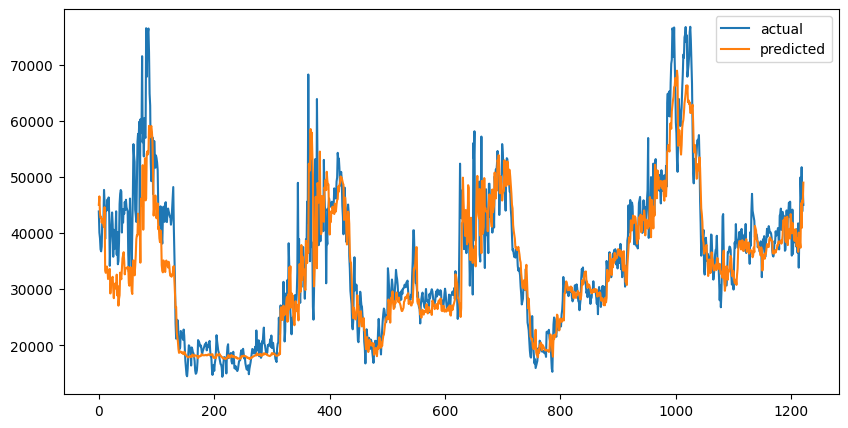

In [249]:
# modelling LSTM
from keras.models import Sequential 
from keras.layers import Dense, LSTM, Dropout 
from keras.callbacks import EarlyStopping 

# data are uesd all data
df = pd.read_excel("core_data.xlsx").dropna()
X = df.drop(["DATE", "avg_price"], axis=1).values
y = df['avg_price'].values

# split data
train_size = int(len(X) * 0.8) 
X_train, X_test = X[:train_size], X[train_size:] 
y_train, y_test = y[:train_size], y[train_size:] 

# reshape
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# model 
model = Sequential() 
model.add(LSTM(50, activation='relu', input_shape=(1, X_train.shape[2])))
model.add(Dense(25, activation='relu'))
model.add(Dense(10, activation='relu'))


model.add(Dense(1)) 
model.compile(optimizer='adam', loss='mse') 

# early stopping 
early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1) 

# fit the model 
model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stop]) 

# predict 
lstm_pred = model.predict(X_test) 

# mse 
y_test_scaled = MinMaxScaler().fit_transform(y_test.reshape(-1,1))
lstm_pred_scaled = MinMaxScaler().fit_transform(lstm_pred.reshape(-1,1))

lstm_mse = mean_squared_error(y_test_scaled, lstm_pred_scaled)
print(f'MSE of LSTM model: {lstm_mse}')

# plot
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='actual') 
plt.plot(lstm_pred, label='predicted') 
plt.legend() 
plt.show() 



MSE of VAR model: 0.2925121818972135
MSE of ensemble model: 3.057581772558541e-09
MSE of LSTM model: 0.009372555458765934
ARIMA model's MSE: 0.04669815066605227
Linear regression model's MSE: 5.630436646941388e-31


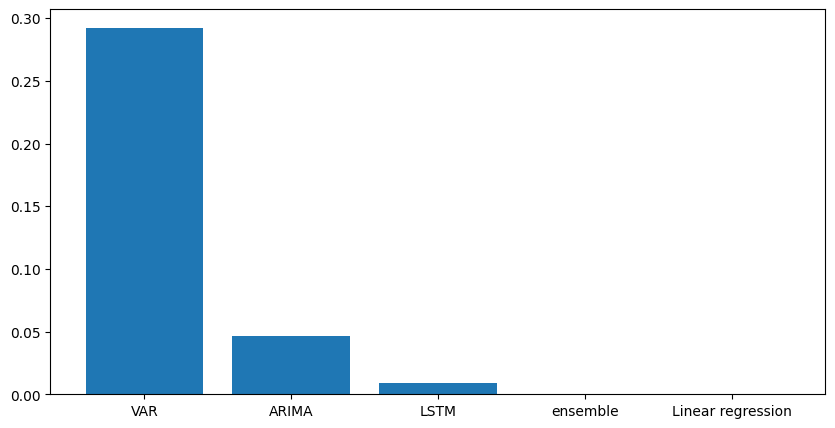

In [261]:
# recall the mse of models
print(f'MSE of VAR model: {VAR_mse}')
print(f'MSE of ensemble model: {ensemble_mse}') 
print(f'MSE of LSTM model: {lstm_mse}') 
print(f"ARIMA model's MSE: {arima_mes}")
print(f"Linear regression model's MSE: {linear_re_mse}")


# plot mse
# by sort the mse
mse = [VAR_mse, ensemble_mse, lstm_mse, arima_mes, linear_re_mse]
model = ['VAR', 'ensemble', 'LSTM', 'ARIMA', 'Linear regression']
mse_df = pd.DataFrame({'model': model, 'mse': mse})
mse_df = mse_df.sort_values(by='mse', ascending=False)

plt.figure(figsize=(10, 5))
plt.bar(mse_df['model'], mse_df['mse']) 
plt.show() 

